In this notebook, we want to extend the summarization dataset with a label classification for each sentence based on whether the professor was writing while they were saying it.  
To perform the classification, we employ a pretrained X-CLIP model ([paper](https://arxiv.org/pdf/2208.02816.pdf), [repo](https://github.com/microsoft/VideoX/tree/master/X-CLIP), [HuggingFace documentation](https://huggingface.co/docs/transformers/main/model_doc/xclip), [usage notebooks](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/X-CLIP)). This model allows us to define the labels that best match the video without having to choose from a pre-determined set.  

The sentence timings can be extrapolated from the WEBVTT transcript files.  
The labels can be injected in the dataset in string format, as special tokens. This allows us to avoid dealing with architectural changes, as BART already supports additional tokens.

In [1]:
!pip install torch numpy transformers pillow pytube av tqdm lox pandas seaborn

In [2]:
import os
from sys import stderr
import json
import math
from typing import Dict, List, Tuple, Union
from pytube import YouTube, Stream
from pytube.exceptions import PytubeError
import torch
import numpy as np
from PIL import Image
import transformers
from transformers import AutoProcessor, AutoModel
import av
import requests
from tqdm.auto import tqdm
import lox
import re
import pandas as pd
import seaborn as sns
import nltk
from transformers import BartTokenizerFast
nltk.download("punkt")

from common import *

print("PyTorch version", torch.__version__)
print("Transformers version", transformers.__version__)

PyTorch version 1.13.0+cu117
Transformers version 4.25.1


[nltk_data] Downloading package punkt to /home/caste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### Define model and labels
#### Model
We test the only zero-shot available X-CLIP variant (here are [all the models](https://github.com/microsoft/VideoX/tree/master/X-CLIP#model-zoo) in the official repo and here are [the models](https://huggingface.co/models?search=microsoft/xclip) on HuggingFace).  
We then decide to use the large variant for higher accuracy.
#### Labels
We test `labels = ["not writing", "writing"]`, but being so generic they mislead the model into classifying as `writing` simple text instead of the speaker in the act of writing.  
We try with `labels = ["not a person writing", "a person writing"]`, but these are still misclassified.  
We try one label only with the explicit verb: `labels = ["a person who is writing"]`. This returns a logits tensor of a float value from around 18 to around 22. But since we only have one value the softmax always returns 1, so this approach isn't feasible.  
We try adding the explicit verb to the two labels: `labels = ["not a person who is writing", "a person who is writing"]`.  

In [ ]:
# model_id = "microsoft/xclip-base-patch16-zero-shot"
model_id = "microsoft/xclip-large-patch14-kinetics-600"
# throws RuntimeError: The size of tensor a (257) must match the size of tensor b (577) at non-singleton dimension 1
# model_id = "microsoft/xclip-large-patch14-16-frames"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(DEVICE)

clip_frames = model.config.vision_config.num_frames
clip_frame_size = model.config.vision_config.image_size  # in X-CLIP height == width
# labels = ["not writing", "writing"]
# labels = ["not a person writing", "a person writing"]
# labels = ["a person who is writing"]
labels = ["not a person who is writing", "a person who is writing"]

f"Using {clip_frames} frames per clip and frame size {clip_frame_size}x{clip_frame_size}"

In [ ]:
dataset = json.load(open(aggregated_dataset_file, "r"))

### Define pyAV (video decoder) functions

The Transformers authors [are discussing](https://github.com/huggingface/datasets/issues/5225) how to integrate a video decoder in their library.  
Generously, one of them has provided [the code on Colab](https://colab.research.google.com/gist/nateraw/c327cb6ff6b074e6ddc8068d19c0367d/pyav-io.ipynb#scrollTo=fzGRpWaUqnTL) for basic video read and write functions implemented on top of pyAV.  
We add some functionality on top, such as ability to specify `frame_width` and `frame_height`.

In [ ]:
def _pyav_decode_stream(
    container: av.container.input.InputContainer,
    start_sec: float,
    end_sec: float,
    frame_width: int,
    frame_height: int,
    stream: av.video.stream.VideoStream,
    perform_seek: bool = True,
) -> Tuple[List, float]:
    """
    Decode the video with PyAV decoder.
    Args:
        container (container): PyAV container.
        start_sec (float): the starting second to fetch the frames.
        end_sec (float): the ending second of the decoded frames.
        stream (stream): PyAV stream.
    Returns:
        result (np.ndarray): np array of decoded frames.
    """

    start_pts = math.ceil(start_sec / stream.time_base)
    end_pts = math.ceil(end_sec / stream.time_base)
    # NOTE:
    # Don't want to seek if iterating through a video due to slow-downs. I
    # believe this is some PyAV bug where seeking after a certain point causes
    # major slow-downs
    if perform_seek:
        # Seeking in the stream is imprecise. Thus, seek to an earlier pts by a
        # margin pts.
        margin = 1024
        seek_offset = max(start_pts - margin, 0)
        container.seek(int(seek_offset), any_frame=False, backward=True, stream=stream)

    frames = []
    stream_info = {'video': 0} if stream.type == 'video' else {'audio': 0}
    for frame in container.decode(**stream_info):
        if frame.pts >= start_pts and frame.pts < end_pts:
            frames.append(frame)
        elif frame.pts >= end_pts:
            break

    if stream.type == 'audio':
        return np.concatenate([x.to_ndarray() for x in frames], 1)
    else:
        try:
            return np.stack([x.to_ndarray(format="rgb24", width=frame_width, height=frame_height) for x in frames])
        except ValueError:
            return None


# Note, went with container here instead of file_path_or_buffer because this way you
# can keep a container loaded in memory and sample over it w/o re-reading it
def read_video_pyav(
    container,
    start_sec: float,
    end_sec: float,
    frame_width: int = None,
    frame_height: int = None,
    decode_audio: bool = True,
    perform_seek: bool = True,
):
    # Handle video stream
    video_stream = container.streams.video[0]
    info = dict(video_fps=video_stream.average_rate)
    video_arr = _pyav_decode_stream(container, start_sec, end_sec, frame_width, frame_height, video_stream, perform_seek)

    # Handle audio stream if desired
    audio_arr = None
    if decode_audio:
        audio_stream = container.streams.audio[0]
        info['audio_sample_rate'] = audio_stream.rate
        audio_arr = _pyav_decode_stream(container, start_sec, end_sec, None, None, audio_stream, perform_seek)

    return video_arr, audio_arr, info

### Define functions to extract sentence-timings correspondences and separate the sentences with `nltk`

In [ ]:
webvtt_ignore_lines_regex = re.compile(r"(?:WEBVTT|Kind: captions|Language: en)", re.IGNORECASE)
webvtt_timecode_regex = re.compile(r"\d{2}:\d{2}:\d{2}\.\d{3}")


def convert_timecode_str2float(timecode: str) -> float:
    hours = int(timecode[0:2])
    minutes = int(timecode[3:5])
    seconds = int(timecode[6:8])
    milliseconds = int(timecode[9:12])
    return (hours * 60 * 60) + (minutes * 60) + seconds + (milliseconds / 1000)


def get_captions(transcript_file_name: str) -> List[Tuple[str, float, float]]:
    captions = []

    with open(transcript_file_name, "r") as f:
        transcript = f.read()

    for line in [l.strip() for l in transcript.split("\n") if len(l.strip()) > 0]:

        if webvtt_ignore_lines_regex.match(line):
            pass

        elif webvtt_timecode_regex.match(line):
            line = line.replace("&gt;", ">")
            splitter = " --> " if " --> " in line else " -> "
            start_timecode, end_timecode = line.split(splitter)
            start_in_seconds = convert_timecode_str2float(start_timecode)
            end_in_seconds = convert_timecode_str2float(end_timecode)
            captions.append({
                'text': "",
                'start': start_timecode,
                'end': end_timecode,
                'start_in_seconds': start_in_seconds,
                'end_in_seconds': end_in_seconds,
            })

        else:
            captions[-1]['text'] = " ".join([captions[-1]['text'], line.strip()]).strip()

    return captions

In [ ]:
def get_sentence_timings(transcript_file_name: str) -> Tuple[List[str], List[Dict[str, float]]]:

    captions = get_captions(transcript_file_name)
    full_transcript = []
    for caption in captions:
        full_transcript.append(caption['text'].replace("\n", " ").strip())
    full_transcript = " ".join(segment for segment in full_transcript if len(segment) > 0)

    sentences = nltk.sent_tokenize(full_transcript)
    timings = []
    sentence_idx = 0
    current_captions_in_sentence = 0

    # we remove the captions from the tokenized sentences one by one
    # this way we can be sure to get all timings
    for caption in captions:
        if current_captions_in_sentence == 0:
            timings.append({'start': caption['start_in_seconds'], 'end': None})

        current_caption = caption['text'].replace("\n", " ")

        # the caption may continue after the end of the sentence
        while sentence_idx <= len(sentences) - 1 and len(current_caption) > len(sentences[sentence_idx]):
            current_caption = current_caption.removeprefix(sentences[sentence_idx]).strip()
            sentences[sentence_idx] = ""
            sentence_idx += 1
            # make up one timing in the middle since the sentence spans across two captions
            # if one sentence is completely contained in the caption, it will have start == end
            # we can ignore this, as only very short sentences would be included
            mid_timing = (caption['start_in_seconds'] + caption['end_in_seconds']) / 2
            timings[-1]['end'] = mid_timing
            timings.append({'start': mid_timing, 'end': None})

        if sentence_idx > len(sentences) - 1:
            timings.pop()
            break

        sentences[sentence_idx] = sentences[sentence_idx].removeprefix(current_caption).strip()
        current_captions_in_sentence += 1

        # we've found the beginning of the next sentence since we've removed
        # every caption from the current sentence
        if len(sentences[sentence_idx]) == 0:
            timings[-1]['end'] = caption['end_in_seconds']
            current_captions_in_sentence = 0
            sentence_idx += 1

    # make sure to not leave the last end timing at None
    timings[-1]['end'] = caption['end_in_seconds']

    assert sum(len(s) for s in sentences) == 0, f"The sentences have not been consumed in their entirety. File: {transcript_file_name}"
    sentences = nltk.sent_tokenize(full_transcript)
    assert len(sentences) == len(timings), f"The number of sentences ({len(sentences)}) is not equal to the number of timings ({len(timings)})."

    return sentences, timings

In [ ]:
def _prepare_inputs_from_clip(
    labels: List[str],
    videos: List[np.ndarray],
) -> Dict[str, torch.FloatTensor]:

    return processor(
        text=labels,
        videos=videos,
        padding=True,
        return_tensors="pt",
    )


def get_speaker_is_writing_classification(
    container: av.container.InputContainer,
    timings: List[Dict[str, float]],
    labels: List[str],
    clip_frames_number: int,
) -> List[int]:
    """
    we want to determine if the clip corresponding to a sentence is classifiable as "writing" or "not writing"
    we have the start and end in seconds of the sentence -> start in frames and end in frames given fps
    we only need to make a linspace from start to end frame of the number of frames the model expects
    """
    is_speaker_writing_during_sentence = []

    # print("Clips to examine:", len(timings))
    inputs_list = []
    for timing in timings:
        if timing['start'] == timing['end']:
            inputs_list.append(None)
        else:
            video_nparrays, audio_nparrays, info = read_video_pyav(
                container,
                start_sec=timing['start'],
                end_sec=timing['end'],
                frame_width=clip_frame_size,
                frame_height=clip_frame_size,
                perform_seek=True,
                decode_audio=False,
            )
            if video_nparrays is None:
                inputs_list.append(None)
                continue
            frame_indices = np.linspace(
                start=0,
                stop=len(video_nparrays) - 1,
                num=clip_frames_number,
            ).astype(np.int64)
            # print("Finished converting to nparrays. Num:", len(videos), "shape:", videos[0][0].shape)
            inputs_list.append(_prepare_inputs_from_clip(labels, list(video_nparrays[frame_indices])))

    for inputs in inputs_list:
        if inputs is None:
            is_speaker_writing_during_sentence.append(None)
        else:
            # important: move input tensors to same device as model
            for k in inputs.keys():
                inputs[k] = inputs[k].to(DEVICE)
            # forward pass
            with torch.no_grad():
                outputs = model(**inputs)
            # avoid GPU memory overflow
            for k in inputs.keys():
                inputs[k] = inputs[k].to("cpu")

            if len(labels) > 1:
                probs = outputs.logits_per_video.softmax(dim=1)
                is_speaker_writing_during_sentence.append(int(torch.argmax(probs)))
            # this approach makes no sense with softmax, leaving the code
            # for future edits
            elif len(labels) == 1:
                # print(outputs.logits_per_video)
                probs = outputs.logits_per_video[0].softmax(dim=-1)
                probability = float(probs)
                is_speaker_writing_during_sentence.append(1 if probability > 0.5 else 0)
            # print("Classified clip:", labels[is_speaker_writing_during_sentence[-1]])

    return is_speaker_writing_during_sentence

### Download the video lectures
The files only get re-downloaded if they're not in the download directory or if they're corrupted.  
The check can be skipped by setting `do_download_or_check` to `False`.  
The total download size on an ext4 filesystem is 222.8 GB or 208 GiB.  

The corrupted video files are these 15/1617 downloaded (leaving 1602/1618 usable videos):
- mitocw_Fundamentals-of-Photovoltaics-Assignments-2011-STUDENT-PROJECT-PRESENTATIONS--PART-1.mp4
- mitocw_Fundamentals-of-Photovoltaics-Assignments-2011-STUDENT-PROJECT-PRESENTATIONS--PART-2.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-3--LIGHT-ABSORPTION-AND-OPTICAL-LOSSES.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-5--CHARGE-SEPARATION--PART-I.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-6--CHARGE-SEPARATION--PART-II.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-7--TOWARD-A-1D-DEVICE-MODEL--PART-I--DEVICE-FUNDAMENTALS.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-9--CHARGE-EXTRACTION.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-15--ADVANCED-CONCEPTS.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-16--SOLAR-CELL-CHARACTERIZATION.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-17--MODULES--SYSTEMS--AND-RELIABILITY.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-18--COST--PRICE--MARKETS--and-SUPPORT-MECHANISMS--PART-I.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-19--COST--PRICE--MARKETS--and-SUPPORT-MECHANISMS--PART-II.mp4
- mitocw_Fundamentals-of-Photovoltaics-Lecture-Videos-and-Slides-2011-LECTURE-20--RandD-INVESTMENT-and-INNOVATION-IN-PV.mp4
- mitocw_Laboratory-Chemistry-Video-Lectures-LECTURE-4--WHAT-S-SIGNIFICANT-IN-LABORATORY-MEASUREMENT--ERROR-ANALYSIS-LECTURE.mp4
- yale_Introduction-to-Ancient-Greek-History-with-Donald-Kagan-9--Sparta-+cont-+.mp4

In [ ]:
@lox.process(os.cpu_count() * 2)
def download_video(url, file_name):
    if not url.startswith("http://") and not url.startswith("https://"):
        url = url.replace("http:/", "http://").replace("https:/", "https://")

    if any(url.startswith(yturl) for yturl in ("https://www.youtube.com/", "https://youtube.com/", "https://www.youtu.be/", "https://youtu.be/")):
        try:
            yt_video = YouTube(url)
            # we use legacy streams: https://pytube.io/en/latest/user/streams.html#dash-vs-progressive-streams
            # res="360p" is enough since X-CLIP base uses 224x224 frames and X-CLIP large uses 336x336
            streams = yt_video.streams.filter(file_extension="mp4", res="360p", type="video", progressive=True)
            # https://pytube.io/en/latest/api.html#pytube.Stream.download
            file_name = streams[0].download(output_path=download_dir, filename=file_name)
        except PytubeError as pyte:
            print(f"\nPytubeError: {pyte}\nFor url {url} -- file {file_name}", file=stderr)
            return None
    else:
        res = requests.get(url, stream=True)
        file_size = int(res.headers.get('Content-Length', 0))
        file_name = f"{download_dir}/{file_name}"
        # download non-existing files and re-download only partially downloaded files
        if not os.path.isfile(file_name) or \
                (os.path.isfile(file_name) and os.path.getsize(file_name) != file_size):
            with open(file_name, 'wb') as f:
                for data in res:
                    f.write(data)

    return file_name

In [ ]:
do_download_or_check = False
download_dir = "./tmp"

if do_download_or_check:
    os.makedirs(download_dir, exist_ok=True)
    for course in dataset:
        for lecture in course['lectures']:
            video_file_name = f"""{course['from_subset']}_{sanitize_lecture_name(f"{course['title']}-{lecture['title']}")}.mp4"""
            download_video.scatter(lecture['video_url'], video_file_name)
    file_names = download_video.gather(tqdm=True)
    print(f"{len([fn for fn in file_names if fn])}/{sum(len(c['lectures']) for c in dataset)} video lectures downloaded.")

### Run X-CLIP inference on summarization dataset's video lectures
This takes approximately 69 hours of runtime between CPU and GPU time on a Ryzen 5 5600X (averaging 4.4 GHz) and an RTX 3090.  
The video classification can be skipped by setting `do_video_classification` to `False`.

In [ ]:
try:
    extended_dataset = json.load(open(extended_dataset_file, "r"))
except FileNotFoundError:
    extended_dataset = []

In [ ]:
# remove latest lecture for testing re-classification
# extended_dataset[-1]['lectures'].pop()

In [ ]:
do_video_classification = False

if do_video_classification:
    total_lectures = sum(len(c['lectures']) for c in dataset)

    discarded_due_to_file_not_found = []
    discarded_due_to_av_errors = []
    discarded_due_to_frame_size_too_small = []

    with tqdm(range(total_lectures)) as progress_bar:
        for c_idx, course in enumerate(dataset):

            # the course has not yet been added to the extended dataset
            if not any(c['url'] == course['url'] for c in extended_dataset):
                extended_dataset.append(course.copy())
                extended_dataset[-1]['lectures'] = []

            for l_idx, lecture in enumerate(course['lectures']):
                # the lecture has not yet been added to the extended dataset
                if not any(l['video_url'] == lecture['video_url'] for l in extended_dataset[c_idx]['lectures']):
                    # videos are hosted on OpenCourseWare
                    if course['from_subset'] == "mitocw":
                        transcript_file_name = f"""../mitocw_lectures_dataset/data/transcripts/{sanitize_lecture_name(f"{course['title']}-{lecture['title']}")}.vtt"""
                        video_file_name = f"""{download_dir}/mitocw_{sanitize_lecture_name(f"{course['title']}-{lecture['title']}")}.mp4"""

                    # videos are hosted on YouTube
                    elif course['from_subset'] == "yale":
                        transcript_file_name = f"""../yale_lectures_dataset/data/transcripts/{sanitize_lecture_name(f"{course['title']}-{lecture['title']}")}.en.vtt"""
                        video_file_name = f"""{download_dir}/yale_{sanitize_lecture_name(f"{course['title']}-{lecture['title']}")}.mp4"""

                    if not os.path.isfile(video_file_name):
                        discarded_due_to_file_not_found.append(video_file_name)
                        print(f"Discarding video due to file not found: {video_file_name}", file=stderr)
                        progress_bar.update()
                        continue

                    try:
                        container = av.open(video_file_name)
                    except Exception as e:  # av.base
                        discarded_due_to_av_errors.append(video_file_name)
                        print(f"Discarding video due to av error ({e}): {video_file_name}", file=stderr)
                        progress_bar.update()
                        continue

                    # check that the video frame size is at least the one required by the model
                    first_frame = next(container.decode(video=0))
                    if min(first_frame.height, first_frame.width) < clip_frame_size:
                        discarded_due_to_frame_size_too_small.append(video_file_name)
                        print(f"Discarding video due to frame size too small ({first_frame.width}x{first_frame.height} < {clip_frame_size}x{clip_frame_size}): {video_file_name}", file=stderr)
                        progress_bar.update()
                        continue

                    sentences, timings = get_sentence_timings(transcript_file_name)
                    is_speaker_writing_during_sentence = get_speaker_is_writing_classification(container, timings, labels, clip_frames)

                    # update extended dataset
                    lecture['transcript'] = {
                        'sentences': sentences,
                        'timings': timings,
                        'is_speaker_writing_during_sentence': is_speaker_writing_during_sentence,
                    }
                    extended_dataset[c_idx]['lectures'].append(lecture)
                    with open(extended_dataset_file, "w") as f:
                        json.dump(extended_dataset, f)

                progress_bar.update()

    print(f"{total_lectures - len(discarded_due_to_file_not_found) - len(discarded_due_to_av_errors) - len(discarded_due_to_frame_size_too_small)}/{total_lectures} classified by {labels} with {model_id}.")
    print(f"{len(discarded_due_to_file_not_found)} discarded due to file not found, {len(discarded_due_to_av_errors)} discarded due to av errors and {len(discarded_due_to_frame_size_too_small)} discarded due to frame size too small.")
    print(f"\n{discarded_due_to_file_not_found=}\n\n{discarded_due_to_av_errors=}\n\n{discarded_due_to_frame_size_too_small=}\n\n")

In [ ]:
if do_video_classification:
    # remove additional lectures from course idx 30 due previous idx bug
    for course, xcourse in zip(dataset, extended_dataset):
        if len(course['lectures']) != len(xcourse['lectures']):
            xcourse['lectures'] = [
                xl for xl in xcourse['lectures'] 
                if any(l['video_url'] == xl['video_url'] for l in course['lectures'])
            ]

    for i, (course, xcourse) in enumerate(zip(dataset, extended_dataset)):
        for xl in xcourse['lectures']:
            assert any(l['video_url'] == xl['video_url'] for l in course['lectures'])

    assert sum(len(xc['lectures']) for xc in extended_dataset) == sum(len(c['lectures']) for c in dataset) - len(discarded_due_to_file_not_found) - len(discarded_due_to_av_errors) - len(discarded_due_to_frame_size_too_small)

    with open(extended_dataset_file, "w") as f:
        json.dump(extended_dataset, f)

### Extend the original dataset with the video labels

For one last time, after visually checking the quality of all the lecture descriptions, remove the spurious parts still contained within them.

In [ ]:
def print_all_descriptions():
    for i, course in enumerate(extended_dataset):
        for j, lecture in enumerate(course['lectures']):
            print(i, j, lecture['description'])
        print()

# print_all_descriptions()

# found to remove:
# (PDF)
# (Courtesy of name surname. Used with permission.)
# Introduction to the Old Testament (Hebrew Bible) (RLST 145) with Christine Hayes
# Timothy Snyder is the Richard C. Levin Professor of History at Yale University and a permanent fellow at the Institute for Human Sciences in Vienna. He speaks five and reads ten European languages. Ukraine must have existed as a society and polity on 23 February 2022, else Ukrainians would not have collectively resisted Russian invasion the next day. What does it mean for a nation to exist? Is this a matter of structures, actions, or both? Why has the existence of Ukraine occasioned such controversy? In what ways are Polish, Russian, and Jewish self-understanding dependent upon experiences in Ukraine? Just how and when did a modern Ukrainian nation emerge? For that matter, how does any modern nation emerge? Why some and not others? Can nations be chosen, and can choices be decisive? If so, whose, and how? Ukraine was the country most touched by Soviet and Nazi terror: what can we learn about those systems, then, from Ukraine? Is the post-colonial, multilingual Ukrainian nation a holdover from the past, or does it hold some promise for the future?

In [ ]:
description_regexes = [
    re.compile(r"\(PDF\)"),
    re.compile(r"\(Courtesy of [\w-]+ \w+\. Used with permission\.\)", re.IGNORECASE),
    re.compile(r"Introduction to the Old Testament \(Hebrew Bible\) \(RLST 145\) with Christine Hayes", re.IGNORECASE),
    re.compile(r"Timothy Snyder is the Richard C\. Levin Professor of History at Yale University and a permanent fellow at the Institute for Human Sciences in Vienna\. He speaks five and reads ten European languages\. Ukraine must have existed as a society and polity on 23 February 2022, else Ukrainians would not have collectively resisted Russian invasion the next day\. What does it mean for a nation to exist\? Is this a matter of structures, actions, or both\? Why has the existence of Ukraine occasioned such controversy\? In what ways are Polish, Russian, and Jewish self-understanding dependent upon experiences in Ukraine\? Just how and when did a modern Ukrainian nation emerge\? For that matter, how does any modern nation emerge\? Why some and not others\? Can nations be chosen, and can choices be decisive\? If so, whose, and how\? Ukraine was the country most touched by Soviet and Nazi terror: what can we learn about those systems, then, from Ukraine\? Is the post-colonial, multilingual Ukrainian nation a holdover from the past, or does it hold some promise for the future\?", re.IGNORECASE),
]

for course in extended_dataset:
    for lecture in course['lectures']:
        for regex in description_regexes:
            matches = re.findall(regex, lecture['description'])
            if matches:
                print(matches)
            for match in matches:
                lecture['description'] = lecture['description'].replace(match, "").strip()

In [ ]:
# print_all_descriptions()

In [ ]:
with open(extended_dataset_file, "w") as f:
    json.dump(extended_dataset, f)

Now to clean the transcripts, we keep in mind that they are separated into sentences, so we adjust the previously written regexes to this situation by splitting them into sentences as well.

In [ ]:
mitocw_regexes = [
    re.compile(r"\[SQUEAKING\]", re.IGNORECASE),
    re.compile(r"\[RUSTLING\]", re.IGNORECASE),
    re.compile(r"\[CLICKING\]", re.IGNORECASE),
    re.compile(r"\[CLICK\]", re.IGNORECASE),
    re.compile(r"(?:NARRATOR: )?The following content is provided under a Creative Commons license\.", re.IGNORECASE),
    re.compile(r"(?:Your|B) support will help MIT Open ?Course[Ww]are continue to offer high[ -]quality,? (?:quality )?educational resources for free\.", re.IGNORECASE),
    re.compile(r"To make a donation,? or (?:to )?view additional materials from (?:hundreds|100(?:'s|s)?) of MIT courses, visit (?:MIT|mit) ?[Oo]pen ?[Cc]ourse[Ww]are(?: at |@)(?:NCAA )?(?:[Oo][Ccs][Ww]|fsae)[.@](?:MIT|mit)\.edu\.?", re.IGNORECASE),
    re.compile(r"Funding for the publication of this video was provided by (?:the )?Gabriell[ae] and Paul Rosenbaum [Ff]oundation\.", re.IGNORECASE),
    re.compile(r"Help OCW continue to provide free and open access to MIT courses by making a donation at (?:MIT )?ocw\.mit\.edu/donate\.", re.IGNORECASE),
]
# mitocw
# "[INAUDIBLE]" remove or add normal token?
# "AUDIENCE", "PROFESSOR", "GUEST SPEAKER", "[CHUCKLES]", "[CHUCKLING]", "[LAUGHTER]", "[LAUGHS]", "[WRITING ON CHALK BOARD]", "[INTERPOSING VOICES]", "[SPEAKING PORTUGUESE]", "[CLASS MURMURS]", "[AUDIENCE GASPS]", "[AUDIENCE LAUGHTER]", "[APPLAUSE]"

# yale
# "(upbeat music)", "(speaking in foreign language)", "(audience cheering)", "(music)", "(energetic music)", "(class applauding)", "(upbeat transition tones)", "[inaudible]"

for course in extended_dataset:
    for lecture in course['lectures']:

        sentences = []
        timings = []
        is_speaker_writing_during_sentence = []

        for i, (sentence, timing, is_speaker_writing) in enumerate(zip(lecture['transcript']['sentences'], lecture['transcript']['timings'], lecture['transcript']['is_speaker_writing_during_sentence'])):
            sentence = sentence.replace("&gt;", ">").replace("&lt;", "<")

            if course['from_subset'] == "mitocw":
                for regex in mitocw_regexes:
                    matches = re.findall(regex, sentence)
                    for match in matches:
                        sentence = sentence.replace(match, "").strip()

            # if the first sentence is not classified, label it as "not writing"
            # to have consistent labels in the following steps
            if i == 0 and is_speaker_writing is None:
                is_speaker_writing = 0

            # if the sentence hasn't been classified or is too short
            # aggregate it with the previous one
            if i > 0 and (is_speaker_writing is None or len(sentence) <= 10):
                sentences[-1] = f"{sentences[-1]} {sentence}".strip()
                timings[-1]['end'] = timing['end']
            else:
                sentences.append(sentence)
                timings.append(timing)
                is_speaker_writing_during_sentence.append(is_speaker_writing)

        lecture['transcript']['sentences'] = sentences
        lecture['transcript']['timings'] = timings
        lecture['transcript']['is_speaker_writing_during_sentence'] = is_speaker_writing_during_sentence

In [ ]:
# remove empty sentences caused by previous loop
removed = 0
total = 0

for course in extended_dataset:
    for lecture in course['lectures']:

        sentences = []
        timings = []
        is_speaker_writing_during_sentence = []

        for sentence, timing, is_speaker_writing in zip(lecture['transcript']['sentences'], lecture['transcript']['timings'], lecture['transcript']['is_speaker_writing_during_sentence']):
            if len(sentence.strip()) > 0:
                sentences.append(sentence)
                timings.append(timing)
                is_speaker_writing_during_sentence.append(is_speaker_writing)
            else:
                removed += 1
            total += 1

        lecture['transcript']['sentences'] = sentences
        lecture['transcript']['timings'] = timings
        lecture['transcript']['is_speaker_writing_during_sentence'] = is_speaker_writing_during_sentence

print(f"Removed {removed} empty sentences out of {total} total sentences.")

In [ ]:
with open(extended_dataset_file, "w") as f:
    json.dump(extended_dataset, f)

### Show dataset stats and save as CSV
We finally convert the list of sentences to a full transcript, in two versions:
1. without special tokens, like the original dataset
2. adding the special tokens that indicate if the speaker was writing while they were saying a sentence or not

In [4]:
special_tokens = [
    "<w>",  # start sentence when the speaker was writing
    "</w>",  # end sentence when the speaker was writing
    "<nw>",  # start sentence when the speaker was not writing
    "</nw>",  # end sentence when the speaker was not writing
]

In [5]:
dataset = json.load(open(extended_dataset_file, "r"))
tokenizer_base = BartTokenizerFast.from_pretrained("facebook/bart-base")
tokenizer_special = BartTokenizerFast.from_pretrained("facebook/bart-base")
tokenizer_special.add_special_tokens({'additional_special_tokens': special_tokens})

4

Since we need to test the final models against different test sets, with bins based on different parameters, we also produce two "test" variants (standard and extended) of this dataset containing more metadata.

In [6]:
tabular_dataset = []
# essentially flatmap
with tqdm(range(sum(len(c['lectures']) for c in dataset))) as progress_bar:
    for course in dataset:
        course_fraction_writing = sum(is_writing for l in course['lectures'] for is_writing in l['transcript']['is_speaker_writing_during_sentence']) / sum(len(l['transcript']['sentences']) for l in course['lectures'])

        for lecture in course['lectures']:
            lecture_fraction_writing = sum(lecture['transcript']['is_speaker_writing_during_sentence']) / len(lecture['transcript']['sentences'])

            transcript_base = " ".join(lecture['transcript']['sentences'])

            transcript_special = []
            for sentence, is_speaker_writing in zip(lecture['transcript']['sentences'], lecture['transcript']['is_speaker_writing_during_sentence']):
                if is_speaker_writing == 0:
                    transcript_special.append(f"{special_tokens[2]}{sentence}{special_tokens[3]}")
                elif is_speaker_writing == 1:
                    transcript_special.append(f"{special_tokens[0]}{sentence}{special_tokens[1]}")
            transcript_special = "".join(transcript_special)

            tabular_dataset.append({
                'from_subset': course['from_subset'],
                'course_title': course['title'],
                'course_url': course['url'],
                'course_macrocategory': macrocategories[course['title']],
                'course_category': categories[course['title']],
                'course_fraction_writing': course_fraction_writing,
                'lecture_title': lecture['title'],
                'lecture_fraction_writing': lecture_fraction_writing,
                'transcript_base': transcript_base,
                'transcript_base_length_characters': len(transcript_base),
                'transcript_base_length_tokens': len(tokenizer_base(transcript_base)['input_ids']),
                'transcript_base_length_words': len(nltk.word_tokenize(transcript_base)),
                'transcript_base_length_sentences': len(nltk.sent_tokenize(transcript_base)),
                'transcript_special': transcript_special,
                'transcript_special_length_characters': len(transcript_special),
                'transcript_special_length_tokens': len(tokenizer_special(transcript_special)['input_ids']),
                'transcript_special_length_words': len(nltk.word_tokenize(transcript_special)),
                'transcript_special_length_sentences': len(nltk.sent_tokenize(transcript_special)),
                'description': lecture['description'],
                'description_length_characters': len(lecture['description']),
                'description_length_tokens': len(tokenizer_base(lecture['description'])['input_ids']),
                'description_length_words': len(nltk.word_tokenize(lecture['description'])),
                'description_length_sentences': len(nltk.sent_tokenize(lecture['description'])),
            })
            progress_bar.update()

  0%|          | 0/1602 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (8383 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9246 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
df = pd.DataFrame(tabular_dataset)
df

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special,transcript_special_length_characters,transcript_special_length_tokens,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences
0,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,"LECTURE 1: SETS, SET OPERATIONS AND MATHEMATIC...",0.795349,CASEY RODRIGUEZ: OK. So I have to admit this i...,34952,...,<w>CASEY RODRIGUEZ: OK.</w><nw>So I have to ad...,37709,9246,10420,5,An introduction to set theory and useful proof...,143,27,25,2
1,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,LECTURE 2: CANTOR'S THEORY OF CARDINALITY (SIZE),0.744589,CASEY RODRIGUEZ: So last time we spoke about--...,38368,...,<w>CASEY RODRIGUEZ: So last time we spoke abou...,41377,10455,11406,7,What does it mean for one set to be bigger tha...,166,41,31,2
2,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,LECTURE 3: CANTOR'S REMARKABLE THEOREM AND THE...,0.736318,CASEY RODRIGUEZ: So here we are again. So I'm ...,35325,...,<nw>CASEY RODRIGUEZ: So here we are again.</nw...,37950,9333,10351,6,Finishing the lecture on Cantor’s notion of ca...,202,44,36,2
3,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,LECTURE 4: THE CHARACTERIZATION OF THE REAL NU...,0.879545,"CASEY RODRIGUEZ: OK, so let's finish the proof...",36920,...,"<nw>CASEY RODRIGUEZ: OK, so let's finish the p...",39667,9793,10843,3,An introduction to properties of fields and or...,129,30,26,2
4,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,"LECTURE 5: THE ARCHIMEDIAN PROPERTY, DENSITY O...",0.779221,"CASEY RODRIGUEZ: Last time, so we're talking a...",38778,...,"<nw>CASEY RODRIGUEZ: Last time, so we're talki...",41755,10434,11479,5,We show that the real numbers satisfy the Arch...,240,51,43,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,yale,Fundamentals of Physics with Ramamurti Shankar,https://www.youtube.com/playlist?list=PLFE3074...,scientific,physics,0.941492,20. Fluid Dynamics and Statics and Bernoulli's...,0.982587,Professor Ramamurti Shankar: This is a relativ...,60623,...,<w>Professor Ramamurti Shankar: This is a rela...,65476,16357,18009,59,The focus of the lecture is on fluid dynamics ...,263,55,47,4
1598,yale,Fundamentals of Physics with Ramamurti Shankar,https://www.youtube.com/playlist?list=PLFE3074...,scientific,physics,0.941492,21. Thermodynamics,0.939266,"Professor Ramamurti Shankar: Alright class, we...",64375,...,"<w>Professor Ramamurti Shankar: Alright class,...",68710,16145,17917,46,This is the first of a series of lectures on t...,489,101,92,7
1599,yale,Fundamentals of Physics with Ramamurti Shankar,https://www.youtube.com/playlist?list=PLFE3074...,scientific,physics,0.941492,22. The Boltzmann Constant and First Law of Th...,0.971710,"So, I had to leave you in the middle of someth...",64491,...,"<w>So, I had to leave you in the middle of som...",69416,16753,18605,29,This lecture continues the topic of thermodyna...,268,53,46,4
1600,yale,Fundamentals of Physics with Ramamurti Shankar,https://www.youtube.com/playlist?list=PLFE3074...,scientific,physics,0.941492,23. The Second Law of Thermodynamics and Carno...,0.968794,Professor Ramamurti Shankar: What I did yester...,55356,...,<w>Professor Ramamurti Shankar: What I did yes...,59631,15094,16295,20,Why does a dropped egg that spatters on the fl...,419,86,76,3


In [8]:
df[['from_subset', 'course_macrocategory', 'course_category', 'course_title', 'course_url', 'lecture_title', 'transcript_base', 'transcript_special', 'description']].describe()

,from_subset,course_macrocategory,course_category,course_title,course_url,lecture_title,transcript_base,transcript_special,description
count,1602,1602,1602,1602,1602,1602,1602,1602,1602
unique,2,2,15,67,67,1590,1601,1602,1592
top,yale,humanities,history,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,1. Introduction,WAI CHEE DIMOCK: So just want to go back very ...,<w>CASEY RODRIGUEZ: OK.</w><nw>So I have to ad...,Machine learning methods used in intelligence ...
freq,893,839,244,58,58,12,2,1,3


#### Show and handle duplicates

In [9]:
df[df.duplicated(subset=['transcript_base'], keep=False)]

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special,transcript_special_length_characters,transcript_special_length_tokens,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences
914,yale,"Hemingway, Fitzgerald, Faulkner with Wai Chee ...",https://www.youtube.com/playlist?list=PL84C3A4...,humanities,literature,0.033316,13. Faulkner -- As I Lay Dying,0.059172,WAI CHEE DIMOCK: So just want to go back very ...,35073,...,<nw>WAI CHEE DIMOCK: So just want to go back v...,37738,8430,9002,18,Professor Wai Chee Dimock begins her discussio...,828,175,154,4
915,yale,"Hemingway, Fitzgerald, Faulkner with Wai Chee ...",https://www.youtube.com/playlist?list=PL84C3A4...,humanities,literature,0.033316,"14. Faulkner -- As I Lay Dying, Part II",0.008876,WAI CHEE DIMOCK: So just want to go back very ...,35073,...,<nw>WAI CHEE DIMOCK: So just want to go back v...,37772,8430,9002,18,Professor Wai Chee Dimock traces Faulkner's ap...,723,158,133,4


In [10]:
df[df.duplicated(subset=['transcript_special'], keep=False)]

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special,transcript_special_length_characters,transcript_special_length_tokens,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences


In [11]:
df[df.duplicated(subset=['description'], keep=False)]

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special,transcript_special_length_characters,transcript_special_length_tokens,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences
309,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Tutorial 3. Machine Learning\nTUTORIAL 3.1: LO...,0.992011,LORENZO ROSASCO: I'm Lorenzo Rosasco. This is ...,54508,...,<nw>LORENZO ROSASCO: I'm Lorenzo Rosasco.</nw>...,59027,14333,16309,186,Machine learning methods used in intelligence ...,255,46,40,3
310,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Tutorial 3. Machine Learning\nTUTORIAL 3.2: LO...,1.000000,LORENZO ROSASCO: So what we want to do now is ...,48613,...,<w>LORENZO ROSASCO: So what we want to do now ...,52304,12470,13914,2,Machine learning methods used in intelligence ...,255,46,40,3
311,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Tutorial 3. Machine Learning\nTUTORIAL 3.3: LO...,1.000000,"LORENZO ROSASCO: If you remember, we did the l...",38251,...,"<w>LORENZO ROSASCO: If you remember, we did th...",41114,9774,11024,7,Machine learning methods used in intelligence ...,255,46,40,3
314,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 1. Neural Circuits of Intelligence\nLECTU...,0.952088,JAMES DICARLO: So let me start by first-- I al...,72320,...,<w>JAMES DICARLO: So let me start by first-- I...,77283,17607,19537,1,Neural circuits underlying object recognition....,256,45,39,3
315,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 1. Neural Circuits of Intelligence\nLECTU...,0.991617,JAMES DICARLO: I'm going to shift more towards...,59831,...,<w>JAMES DICARLO: I'm going to shift more towa...,64856,15001,17211,9,Neural circuits underlying object recognition....,256,45,39,3
317,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 1. Neural Circuits of Intelligence\nLECTU...,0.819957,What I'm going to be talking about is some of ...,46345,...,<nw>What I'm going to be talking about is some...,49278,10817,11753,14,The role of the hippocampus in forming episodi...,243,42,39,2
318,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 1. Neural Circuits of Intelligence\nLECTU...,0.986441,"MATT WILSON: Now, why are we interested in sle...",25805,...,"<w>MATT WILSON: Now, why are we interested in ...",27584,5942,6635,2,The role of the hippocampus in forming episodi...,243,42,39,2
320,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 2. Modeling Human Cognition\nLECTURE 2.1:...,0.962185,JOSH TENENBAUM: I'm going to be talking about ...,65665,...,<w>JOSH TENENBAUM: I'm going to be talking abo...,70004,16026,17740,49,Exploring how humans learn new concepts and ma...,230,42,35,2
321,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 2. Modeling Human Cognition\nLECTURE 2.2:...,0.998643,JOSH TENENBAUM: We're going to-- I'm just goin...,78207,...,<w>JOSH TENENBAUM: We're going to-- I'm just g...,82632,18386,20026,10,Exploring how humans learn new concepts and ma...,230,

In [12]:
_df_len_before = len(df)
df.drop_duplicates(subset=['transcript_base'], keep="first", inplace=True)
_df_len_after = len(df)
print(f"Removed {_df_len_before - _df_len_after} duplicate transcripts.")

Removed 1 duplicate transcripts.


Since some descriptions are duplicates, it means they are not a lecture-specific summary, so the model would have difficulty learning the transcript-summary association from them. Hence, we get rid of all instances of duplicate descriptions.

In [13]:
_df_len_before = len(df)
df.drop_duplicates(subset=['description'], keep=False, inplace=True)
_df_len_after = len(df)
print(f"Removed {_df_len_before - _df_len_after} duplicate descriptions.")

Removed 18 duplicate descriptions.


In [14]:
df[['from_subset', 'course_macrocategory', 'course_category', 'course_title', 'course_url', 'lecture_title', 'transcript_base', 'transcript_special', 'description']].describe()

,from_subset,course_macrocategory,course_category,course_title,course_url,lecture_title,transcript_base,transcript_special,description
count,1583,1583,1583,1583,1583,1583,1583,1583,1583
unique,2,2,15,67,67,1571,1583,1583,1583
top,yale,humanities,history,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,1. Introduction,CASEY RODRIGUEZ: OK. So I have to admit this i...,<w>CASEY RODRIGUEZ: OK.</w><nw>So I have to ad...,An introduction to set theory and useful proof...
freq,890,836,242,42,42,12,1,1,1


In [15]:
df[['course_fraction_writing', 'lecture_fraction_writing']].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,course_fraction_writing,lecture_fraction_writing
count,1583.000000,1583.000000
mean,0.458567,0.455654
std,0.285023,0.317238
min,0.008263,0.000000
25%,0.195763,0.136765
50%,0.502309,0.481030
75%,0.689581,0.734116
90%,0.815308,0.882100
95%,0.906653,0.945180
99%,0.952705,0.982840


From the table above, we can see that the "writing" classification is within [0.008, 0.953] for courses (averaging all the classifications for all the lectures of the course) and within [0.000, 1.000] for single lectures.  
We can use [`pandas.qcut`](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) to split the lectures automatically into q equally sized bins based on the writing classification frequency.

In [16]:
df['lectures_writing_frequency'] = pd.qcut(df['lecture_fraction_writing'], q=3, labels=["infrequent writing", "medium frequent writing", "frequent writing"])

In [17]:
df['courses_writing_frequency'] = pd.qcut(df['course_fraction_writing'], q=3, labels=["infrequent writing", "medium frequent writing", "frequent writing"])

In [18]:
df[['lectures_writing_frequency', 'courses_writing_frequency']].describe()

,lectures_writing_frequency,courses_writing_frequency
count,1583,1583
unique,3,3
top,infrequent writing,infrequent writing
freq,528,545


<AxesSubplot: xlabel='courses_writing_frequency', ylabel='Count'>

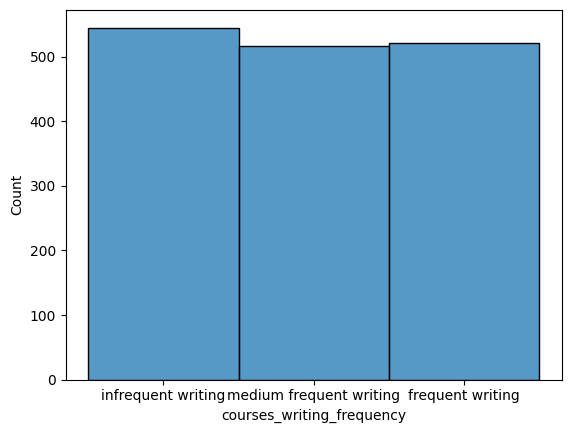

In [19]:
sns.histplot(df['courses_writing_frequency'])

<AxesSubplot: xlabel='lectures_writing_frequency', ylabel='Count'>

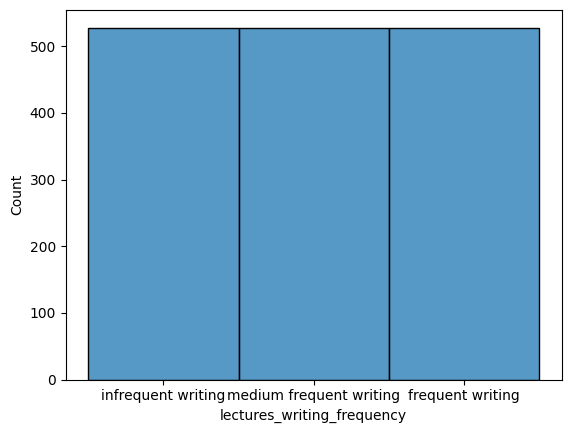

In [20]:
sns.histplot(df['lectures_writing_frequency'])

<AxesSubplot: xlabel='course_fraction_writing', ylabel='Count'>

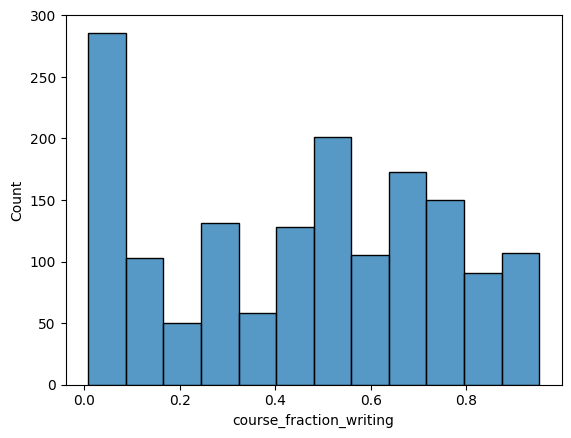

In [21]:
sns.histplot(df['course_fraction_writing'])

<AxesSubplot: xlabel='lecture_fraction_writing', ylabel='Count'>

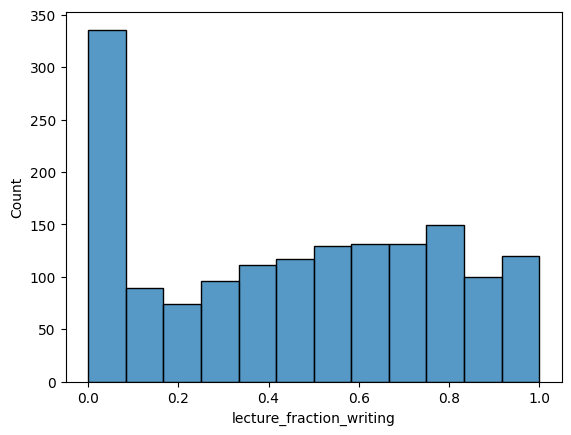

In [22]:
sns.histplot(df['lecture_fraction_writing'])

In [23]:
df[['transcript_base_length_tokens', 'transcript_special_length_tokens', 'description_length_tokens']].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.938, 0.95, 0.980, 0.99])

,transcript_base_length_tokens,transcript_special_length_tokens,description_length_tokens
count,1583.000000,1583.000000,1583.000000
mean,9738.670878,10674.812382,100.566646
std,3132.797312,3471.040703,61.880491
min,472.000000,512.000000,6.000000
25%,7563.000000,8260.000000,48.000000
50%,8925.000000,9766.000000,89.000000
75%,12135.000000,13229.000000,140.000000
90%,14249.400000,15730.200000,183.800000
93.8%,14848.748000,16381.496000,207.916000
95%,15078.900000,16643.800000,217.900000


From the table above, we notice that introducing the special tokens we increase the mean transcript length from 9739 to 10675, or by 9.61%.  
This means that, while with the base transcripts we have a dataset tokenizable at the 98.0th percentile, now we are down to the 93.8th percentile, which reduces the amount of complete transcripts we're going to be able to feed the model.

In [24]:
#sns.set(rc={"figure.figsize": (16, 9)})  # change seaborn plot size
sns.set_style("whitegrid")

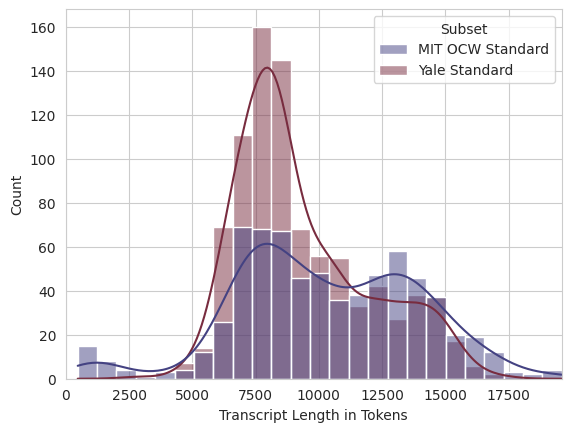

In [25]:
# docs: https://seaborn.pydata.org/generated/seaborn.histplot.html
# custom legend: https://stackoverflow.com/a/45211976
# good color palettes are viridis and icefire (but the colors are similar): https://seaborn.pydata.org/tutorial/color_palettes.html
axes = sns.histplot(df, x="transcript_base_length_tokens", hue="from_subset", kde=True, palette="icefire")
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_base_length_tokens'])))

axes.legend_.set_title("Subset")
for t, l in zip(axes.legend_.texts, ["MIT OCW Standard", "Yale Standard"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_standard_transcript_length_tokens_distribution_subsets.svg")

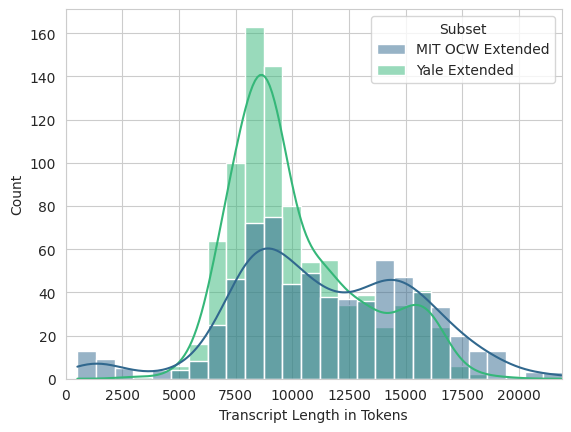

In [26]:
axes = sns.histplot(df, x="transcript_special_length_tokens", hue="from_subset", kde=True, palette="viridis")
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_special_length_tokens'])))

axes.legend_.set_title("Subset")
for t, l in zip(axes.legend_.texts, ["MIT OCW Extended", "Yale Extended"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_extended_transcript_length_tokens_distribution_subsets.svg")

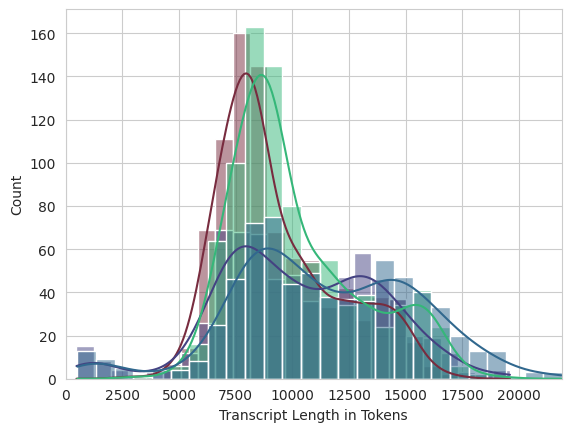

In [27]:
axes = sns.histplot(df, x="transcript_base_length_tokens", hue="from_subset", kde=True, palette="icefire", legend=False)
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_base_length_tokens'])))

axes = sns.histplot(df, x="transcript_special_length_tokens", hue="from_subset", kde=True, palette="viridis", legend=False)
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_special_length_tokens'])))

fig = axes.get_figure()
fig.savefig("unisum_standard+extended_transcript_length_tokens_distribution_subsets.svg")

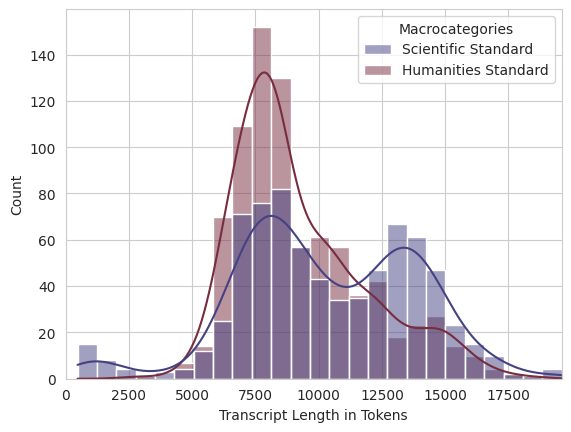

In [28]:
# docs: https://seaborn.pydata.org/generated/seaborn.histplot.html
# custom legend: https://stackoverflow.com/a/45211976
# good color palettes are viridis and icefire (but the colors are similar): https://seaborn.pydata.org/tutorial/color_palettes.html
axes = sns.histplot(df, x="transcript_base_length_tokens", hue="course_macrocategory", kde=True, palette="icefire")
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_base_length_tokens'])))

axes.legend_.set_title("Macrocategories")
for t, l in zip(axes.legend_.texts, ["Scientific Standard", "Humanities Standard"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_standard_transcript_length_tokens_distribution_macrocategories.svg")

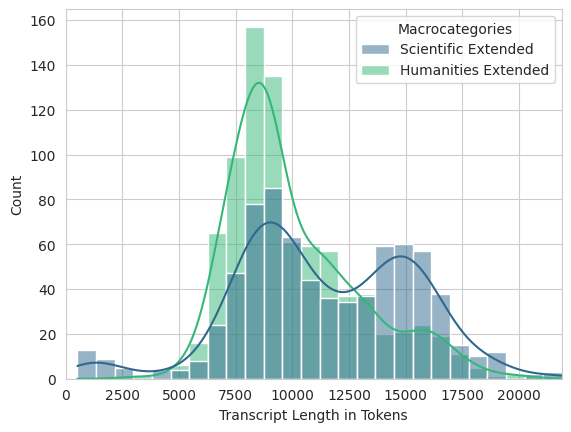

In [29]:
axes = sns.histplot(df, x="transcript_special_length_tokens", hue="course_macrocategory", kde=True, palette="viridis")
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_special_length_tokens'])))

axes.legend_.set_title("Macrocategories")
for t, l in zip(axes.legend_.texts, ["Scientific Extended", "Humanities Extended"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_extended_transcript_length_tokens_distribution_macrocategories.svg")

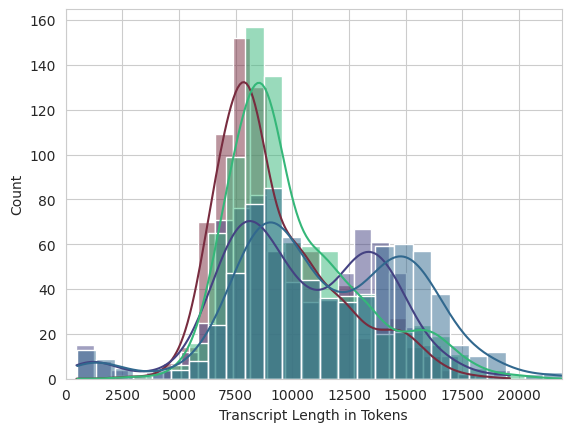

In [30]:
axes = sns.histplot(df, x="transcript_base_length_tokens", hue="course_macrocategory", kde=True, palette="icefire", legend=False)
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_base_length_tokens'])))

axes = sns.histplot(df, x="transcript_special_length_tokens", hue="course_macrocategory", kde=True, palette="viridis", legend=False)
axes.set(xlabel="Transcript Length in Tokens", xlim=(0, max(df['transcript_special_length_tokens'])))

fig = axes.get_figure()
fig.savefig("unisum_standard+extended_transcript_length_tokens_distribution_macrocategories.svg")

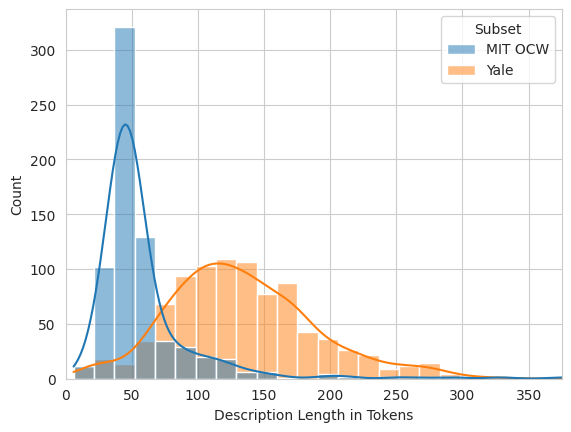

In [31]:
# docs: https://seaborn.pydata.org/generated/seaborn.histplot.html
# custom legend: https://stackoverflow.com/a/45211976
# good color palettes are viridis and icefire (but the colors are similar): https://seaborn.pydata.org/tutorial/color_palettes.html
axes = sns.histplot(df, x="description_length_tokens", hue="from_subset", kde=True)
axes.set(xlabel="Description Length in Tokens", xlim=(0, max(df['description_length_tokens'])))

axes.legend_.set_title("Subset")
for t, l in zip(axes.legend_.texts, ["MIT OCW", "Yale"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_description_length_tokens_distribution_subsets.svg")

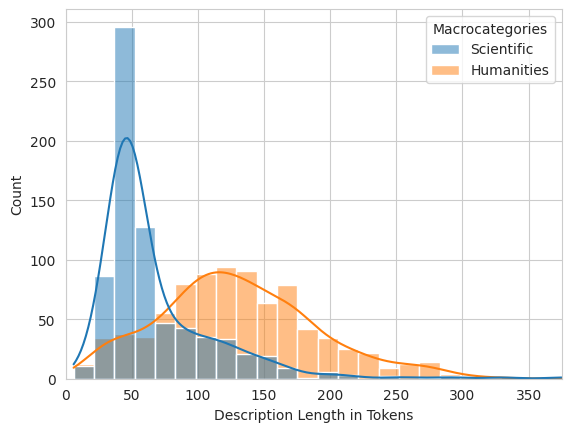

In [32]:
axes = sns.histplot(df, x="description_length_tokens", hue="course_macrocategory", kde=True)
axes.set(xlabel="Description Length in Tokens", xlim=(0, max(df['description_length_tokens'])))

axes.legend_.set_title("Macrocategories")
for t, l in zip(axes.legend_.texts, ["Scientific", "Humanities"]):
    t.set_text(l)

fig = axes.get_figure()
fig.savefig("unisum_description_length_tokens_distribution_macrocategories.svg")

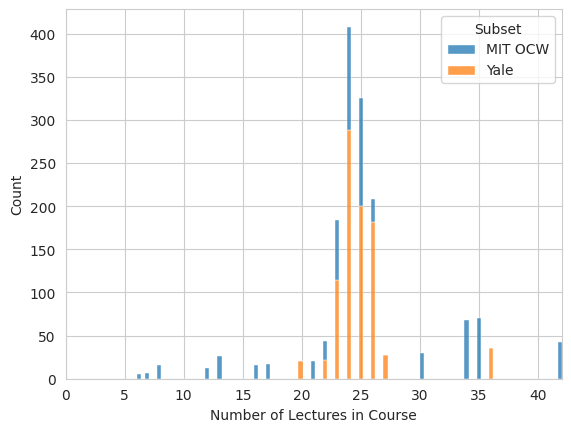

In [33]:
# length of courses in terms of lectures

# https://stackoverflow.com/a/63255023
df['lectures_number'] = df['course_url'].map(df['course_url'].value_counts())

axes = sns.histplot(df, x="lectures_number", hue="from_subset", kde=False, multiple="stack")
axes.set(xlabel="Number of Lectures in Course", xlim=(0, max(df['lectures_number'])), xticks=range(0, max(df['lectures_number']), 5))
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.legend_.set_title("Subset")
for t, l in zip(axes.legend_.texts, ["MIT OCW", "Yale"]):
    t.set_text(l)
fig = axes.get_figure()
fig.savefig("unisum_lectures_per_course_distribution.svg")

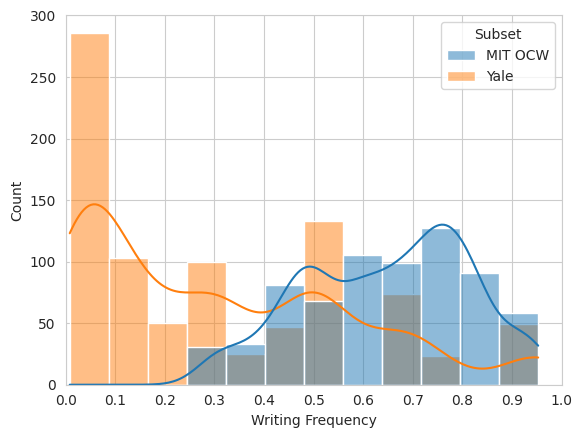

In [34]:
# distribution of courses_writing_frequency

axes = sns.histplot(df, x="course_fraction_writing", hue="from_subset", kde=True)
axes.set(xlabel="Writing Frequency", xlim=(0, 1), xticks=[n / 100 for n in range(0, 110, 10)])
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.legend_.set_title("Subset")
for t, l in zip(axes.legend_.texts, ["MIT OCW", "Yale"]):
    t.set_text(l)
fig = axes.get_figure()
fig.savefig("unisum_courses_writing_frequency_distribution_subsets.svg")

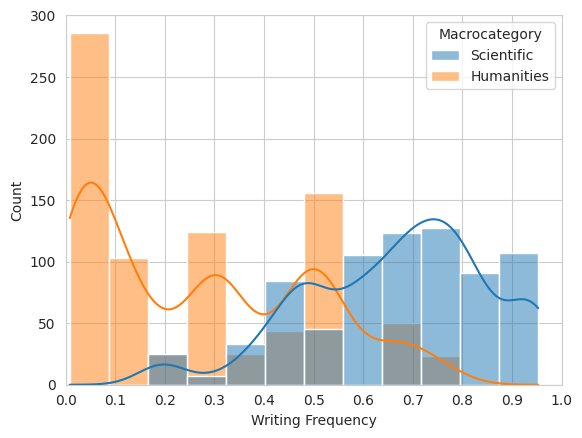

In [35]:
# distribution of courses_writing_frequency

axes = sns.histplot(df, x="course_fraction_writing", hue="course_macrocategory", kde=True)
axes.set(xlabel="Writing Frequency", xlim=(0, 1), xticks=[n / 100 for n in range(0, 110, 10)])
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.legend_.set_title("Macrocategory")
for t, l in zip(axes.legend_.texts, ["Scientific", "Humanities"]):
    t.set_text(l)
fig = axes.get_figure()
fig.savefig("unisum_courses_writing_frequency_distribution_macrocategories.svg")

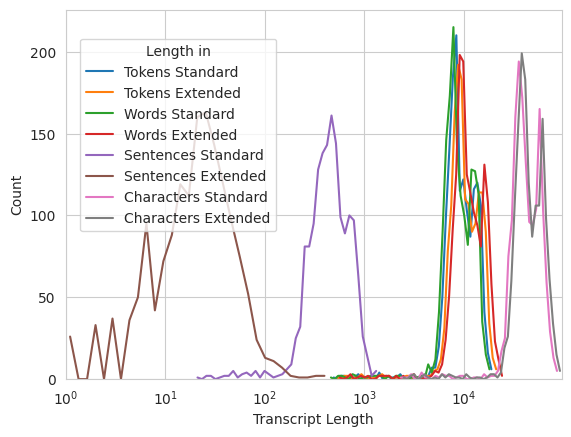

In [36]:
# correlation between the four types of transcript length
transcript_length_keys = [
    "transcript_base_length_tokens",
    "transcript_special_length_tokens",
    "transcript_base_length_words",
    "transcript_special_length_words",
    "transcript_base_length_sentences",
    "transcript_special_length_sentences",
    "transcript_base_length_characters",
    "transcript_special_length_characters",
]
for x in transcript_length_keys:
    axes = sns.histplot(df, x=x, element="poly", log_scale=True, fill=False)
    axes.set(xlabel="Transcript Length", xlim=(1, max(df['transcript_special_length_characters'])))

fig = axes.get_figure()
fig.legend(title="Length in", loc=(0.14, 0.47), labels=[f"{k.split('_')[-1].title()} {'Standard' if 'base' in k else 'Extended'}" for k in transcript_length_keys])
fig.savefig("unisum_standard+extended_transcript_length_tokens_vs_words_vs_sentences_vs_characters.svg")

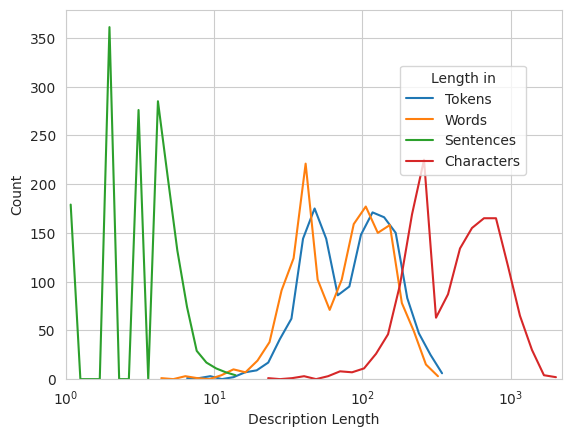

In [37]:
# correlation between the four types of description length
description_length_keys = [
    "description_length_tokens",
    "description_length_words",
    "description_length_sentences",
    "description_length_characters",
]
for x in description_length_keys:
    axes = sns.histplot(df, x=x, element="poly", log_scale=True, fill=False)
    axes.set(xlabel="Description Length", xlim=(1, max(df['description_length_characters'])))

fig = axes.get_figure()
fig.legend(title="Length in", loc=(0.7, 0.6), labels=[k.split('_')[-1].title() for k in description_length_keys])
fig.savefig("unisum_standard+extended_description_length_tokens_vs_words_vs_sentences_vs_characters.svg")

In [38]:
seed = 42
np.random.seed(seed)

In [39]:
def split_dataframe(df, make_test_split: bool = True):

    train_split = 0.8
    dev_split = test_split = 0.1

    if not make_test_split:
        train_split += test_split
        test_split = 0.

    train, dev, test = np.split(
        df.sample(frac=1, random_state=seed),
        [int(train_split * len(df)), int((train_split + dev_split) * len(df))],
    )
    print(len(train), len(train) / len(df), len(dev), len(dev) / len(df), len(test), len(test) / len(df), len(train) + len(dev) + len(test) == len(df))

    return train, dev, test

#### 1. Make dataset without additional special tokens

In [40]:
df_base = df[['transcript_base', 'description']].copy()

In [41]:
df_base.rename(columns={'transcript_base': 'text', 'description': 'target'}, inplace=True)

In [42]:
df_base.head(2)

,text,target
0,CASEY RODRIGUEZ: OK. So I have to admit this i...,An introduction to set theory and useful proof...
1,CASEY RODRIGUEZ: So last time we spoke about--...,What does it mean for one set to be bigger tha...


In [43]:
train_base, dev_base, test_base = split_dataframe(df_base)

1266 0.7997473152242578 158 0.0998104864181933 159 0.10044219835754896 True


In [44]:
train_base.head(3)

,text,target
1050,Prof: Okay. Well this week and next week I'm g...,Professor Wrightson provides a broad sketch of...
312,NANCY KANWISHER: So I'm going to talk today ab...,Functional architecture of the human brain. Hi...
1362,Professor Amy Hungerford: We finished Black Bo...,Professor Amy Hungerford's first lecture on Fl...


In [45]:
dev_base.head(3)

,text,target
562,"RICHARD SCHMALENSEE: So today, we're going to ...",This lecture focuses on the state of non-renew...
674,Hi. This is the first lecture in MIT's course ...,A major application of linear algebra is to so...
1311,Prof: Very good. So today we're going to talk ...,The Tree of Life must be discovered through ri...


In [46]:
test_base.head(3)

,text,target
1480,Professor Robert Shiller: Today I want to talk...,Options introduce an essential nonlineary into...
500,PROFESSOR: Are you guys excited about Battleco...,"This lecture introduces Battlecode, course and..."
95,"PROFESSOR: Last time, we started discussing gr...","Continuing the discussion of graph limits, Pro..."


In [47]:
train_base.to_csv(train_split_csv_file)
dev_base.to_csv(dev_split_csv_file)
test_base.to_csv(test_split_csv_file)

#### 2. Make dataset with additional special tokens

In [48]:
df_special = df[['transcript_special', 'description']].copy()

In [49]:
df_special.rename(columns={'transcript_special': 'text', 'description': 'target'}, inplace=True)

In [50]:
df_special.head(2)

,text,target
0,<w>CASEY RODRIGUEZ: OK.</w><nw>So I have to ad...,An introduction to set theory and useful proof...
1,<w>CASEY RODRIGUEZ: So last time we spoke abou...,What does it mean for one set to be bigger tha...


In [51]:
train_special, dev_special, test_special = split_dataframe(df_special)

1266 0.7997473152242578 158 0.0998104864181933 159 0.10044219835754896 True


In [52]:
train_special.head(3)

,text,target
1050,<w>Prof: Okay.</w><nw>Well this week and next ...,Professor Wrightson provides a broad sketch of...
312,<nw>NANCY KANWISHER: So I'm going to talk toda...,Functional architecture of the human brain. Hi...
1362,<nw>Professor Amy Hungerford: We finished Blac...,Professor Amy Hungerford's first lecture on Fl...


In [53]:
dev_special.head(3)

,text,target
562,"<nw>RICHARD SCHMALENSEE: So today, we're going...",This lecture focuses on the state of non-renew...
674,<w>Hi.</w><w>This is the first lecture in MIT'...,A major application of linear algebra is to so...
1311,<w>Prof: Very good.</w><nw>So today we're goin...,The Tree of Life must be discovered through ri...


In [54]:
test_special.head(3)

,text,target
1480,<nw>Professor Robert Shiller: Today I want to ...,Options introduce an essential nonlineary into...
500,<nw>PROFESSOR: Are you guys excited about Batt...,"This lecture introduces Battlecode, course and..."
95,"<nw>PROFESSOR: Last time, we started discussin...","Continuing the discussion of graph limits, Pro..."


In [55]:
train_special.to_csv(train_split_extended_csv_file)
dev_special.to_csv(dev_split_extended_csv_file)
test_special.to_csv(test_split_extended_csv_file)

#### 3. Make dataset for testing
This will include both the standard and the extended transcripts, and all metadata which could be useful for filtering and aggregating different test sets.  
In this way, a single testing dataset is enough.

In [56]:
df_testing = df.copy()

In [57]:
df_testing.head(2)

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences,lectures_writing_frequency,courses_writing_frequency,lectures_number
0,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,"LECTURE 1: SETS, SET OPERATIONS AND MATHEMATIC...",0.795349,CASEY RODRIGUEZ: OK. So I have to admit this i...,34952,...,10420,5,An introduction to set theory and useful proof...,143,27,25,2,frequent writing,frequent writing,25
1,mitocw,Real Analysis,https://ocw.mit.edu/courses/18-100a-real-analy...,scientific,mathematics,0.769003,LECTURE 2: CANTOR'S THEORY OF CARDINALITY (SIZE),0.744589,CASEY RODRIGUEZ: So last time we spoke about--...,38368,...,11406,7,What does it mean for one set to be bigger tha...,166,41,31,2,frequent writing,frequent writing,25


In [58]:
train_testing, dev_testing, test_testing = split_dataframe(df_testing)

1266 0.7997473152242578 158 0.0998104864181933 159 0.10044219835754896 True


In [59]:
# for testing we don't care about training and validation datasets separation
# but we care about having the test set equal to the standard and extended datasets
other_testing = pd.concat([train_testing, dev_testing])

In [60]:
other_testing.head(3)

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences,lectures_writing_frequency,courses_writing_frequency,lectures_number
1050,yale,Early Modern England with Keith E. Wrightson,https://www.youtube.com/playlist?list=PL18B9F1...,humanities,history,0.238987,"2. ""The Tree of Commonwealth"": The Social Orde...",0.029167,Prof: Okay. Well this week and next week I'm g...,33100,...,7597,15,Professor Wrightson provides a broad sketch of...,999,185,165,5,infrequent writing,infrequent writing,25
312,mitocw,"Brains, Minds and Machines Summer Course",https://ocw.mit.edu/courses/res-9-003-brains-m...,scientific,computer science,0.832022,Unit 1. Neural Circuits of Intelligence\nLECTU...,0.865044,NANCY KANWISHER: So I'm going to talk today ab...,43966,...,11190,28,Functional architecture of the human brain. Hi...,187,31,27,3,frequent writing,frequent writing,42
1362,yale,The American Novel Since 1945 with Amy Hungerford,https://www.youtube.com/playlist?list=PLE33BCD...,humanities,literature,0.056103,"3. Flannery O'Connor, Wise Blood",0.008197,Professor Amy Hungerford: We finished Black Bo...,35410,...,9716,44,Professor Amy Hungerford's first lecture on Fl...,437,89,78,4,infrequent writing,infrequent writing,26


In [61]:
test_testing.head(3)

,from_subset,course_title,course_url,course_macrocategory,course_category,course_fraction_writing,lecture_title,lecture_fraction_writing,transcript_base,transcript_base_length_characters,...,transcript_special_length_words,transcript_special_length_sentences,description,description_length_characters,description_length_tokens,description_length_words,description_length_sentences,lectures_writing_frequency,courses_writing_frequency,lectures_number
1480,yale,Financial Markets (2008) with Robert Shiller,https://www.youtube.com/playlist?list=PL8F7E25...,humanities,economics,0.306197,23. Options Markets,0.600877,Professor Robert Shiller: Today I want to talk...,48169,...,12979,7,Options introduce an essential nonlineary into...,726,135,129,6,medium frequent writing,infrequent writing,26
500,mitocw,The Battlecode Programming Competition,https://ocw.mit.edu/courses/6-370-the-battleco...,scientific,computer science,0.399673,Lecture Videos\nLECTURE 1: INTRODUCTION TO BAT...,0.334641,PROFESSOR: Are you guys excited about Battleco...,52773,...,15902,34,"This lecture introduces Battlecode, course and...",191,34,31,1,medium frequent writing,medium frequent writing,8
95,mitocw,Graph Theory and Additive Combinatorics,https://ocw.mit.edu/courses/18-217-graph-theor...,scientific,mathematics,0.767883,Video Lectures\nLECTURE 15: GRAPH LIMITS II: R...,0.787449,"PROFESSOR: Last time, we started discussing gr...",42162,...,11407,27,"Continuing the discussion of graph limits, Pro...",270,56,48,1,frequent writing,frequent writing,26


In [62]:
other_testing.to_csv(other_split_testing_csv_file)
test_testing.to_csv(test_split_testing_csv_file)